# Modèle Support Vector Machine

# Importation des librairies

In [19]:
import numpy as np
import pandas as pd
import os
import importlib
from ClassificationModel import ClassificationModel
from sklearn import model_selection, preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
import itertools
import shap
import pickle
import sys

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm.autonotebook import tqdm 

sys.stdout.flush()


# Définition des fonctions de sauvegarde

In [3]:

def modelAlreadyTrain(filename):
    return os.path.isfile('../models/' + filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

## Récupération des données 
### Classification de la valeur cible suivant la nomenclature suivante

Emissions de CO2:
- A : inférieures ou égales à 100 g/km
- B : de 101 à 120 g/km
- C : de 121 à 140 g/km
- D : de 141 à 160 g/km
- E : de 161 à 200 g/km
- F : de 201 à 250 g/km
- G : supérieures à 250 g/km

In [4]:
df=pd.read_csv('../../Data/Processed/Co2_final.csv')

def l_claspol(x):
    if x <= 100:
        x = 1
    elif x <= 120:
        x = 2
    elif x <= 140:
        x = 3
    elif x <= 160:
        x = 4
    elif x <= 200:
        x = 5
    elif x <= 250:
        x = 6
    else:
        x = 7
    return x

df['Ewltp (g/km)']=df.apply(lambda x: l_claspol(x['Ewltp (g/km)']), axis=1)

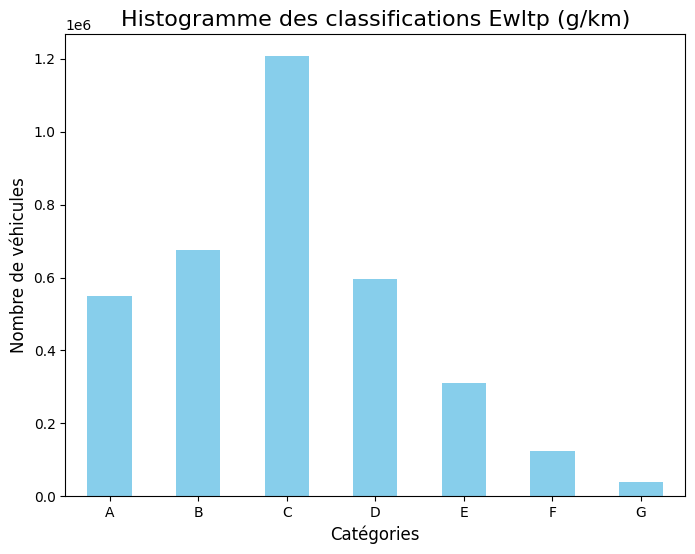

In [34]:
# Tracer l'histogramme avec remplacement des valeurs pour l'affichage
plt.figure(figsize=(8, 6))

# Tracer l'histogramme sans modifier le DataFrame
ax = df['Ewltp (g/km)'].value_counts().sort_index().plot(kind='bar', color='skyblue')

# Remplacer les valeurs sur l'axe des x pour l'affichage (1->A, 2->B, etc.)
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'], rotation=0)

# Ajouter un titre et des labels
plt.title('Histogramme des classifications Ewltp (g/km)', fontsize=16)
plt.xlabel('Catégories', fontsize=12)
plt.ylabel('Nombre de véhicules', fontsize=12)

# Afficher le graphique
plt.show()

### Création des jeux de données d'entrainement et des jeux de données de test

In [5]:
X = df.drop(columns=['Ewltp (g/km)', 'ID'])
y = df['Ewltp (g/km)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Calculer le nombre d'échantillons à sélectionner : 5% du total soit 6,25% de 80%
n_samples = int(0.0625 * len(X_train))

# Sélectionner aléatoirement les indices de X_train avec un random_state pour la reproductibilité
#random_indices = np.random.choice(len(X_train), size=n_samples, replace=False, random_state=42)
rdmstt = np.random.RandomState(42)
random_indices = rdmstt.choice(len(X_train), size=n_samples, replace=False)

# Sélectionner X_train_sample et y_train_sample
X_train_sample = X_train[random_indices]
y_train_sample = y_train.iloc[random_indices]

# Afficher les dimensions de l'échantillon sélectionné
print("Dimensions de l'échantillon sélectionné de X_train : ", X_train_sample.shape)
print("Dimensions de l'échantillon sélectionné de y_train : ", y_train_sample.shape)

Dimensions de l'échantillon sélectionné de X_train :  (174939, 22)
Dimensions de l'échantillon sélectionné de y_train :  (174939,)


In [22]:
# 4. Définir les paramètres à tester dans le GridSearch
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],  # Noyaux à tester
    'C': [0.1, 1, 10],  # Valeurs de C pour tester
    'gamma': ['scale', 'auto'],  # Valeurs de gamma (appliqué uniquement aux noyaux 'rbf' et 'poly')
    'degree': [2, 3],  # Degré du polynôme (applicable uniquement pour le noyau 'poly')
    'coef0': [0, 1]  # Paramètre pour le noyau 'poly' et 'sigmoid'
}

# 5. Créer un modèle SVM
svm = SVC(random_state=42)

# 6. Configurer le GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)

# 7. Effectuer le Grid Search sur l'échantillon d'entraînement
grid_search.fit(X_train_sample, y_train_sample)

# 8. Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs paramètres : {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


In [25]:
gridresults=pd.DataFrame.from_dict(grid_search.cv_results_).loc[:,['params', 'mean_test_score']]
print(gridresults)

                                               params  mean_test_score
0   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.847781
1   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.848273
2   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.835840
3   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.847781
4   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.519038
..                                                ...              ...
67  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 's...         0.972911
68  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 's...         0.962644
69  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 'a...         0.963936
70  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 'a...         0.954899
71  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 'a...         0.942214

[72 rows x 2 columns]


In [27]:
gridresults.to_csv('svmGSResults.csv', index=False)

     C  coef0  degree  gamma  kernel  mean_test_score
0  0.1      0       2  scale  linear         0.847781
1  0.1      0       2  scale    poly         0.848273
2  0.1      0       2  scale     rbf         0.835840
3  0.1      0       2   auto  linear         0.847781
4  0.1      0       2   auto    poly         0.519038


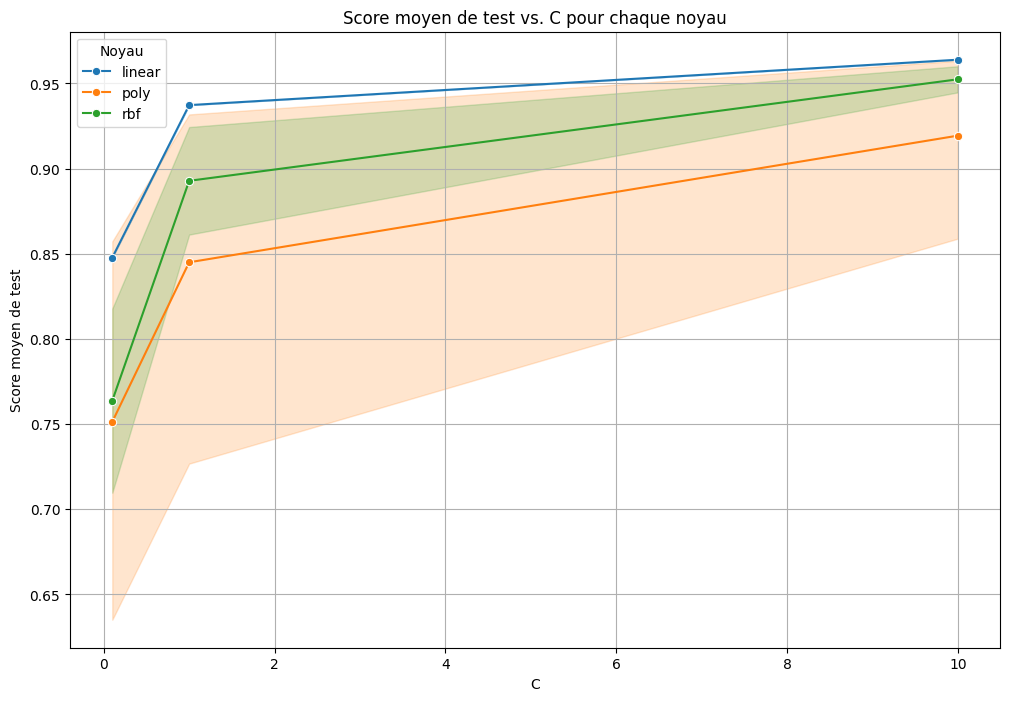

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supposons que grid_search soit déjà effectué
# gridresults = pd.DataFrame.from_dict(grid_search.cv_results_).loc[:, ['params', 'mean_test_score']]

# Extraire les paramètres du GridSearch
params_df = pd.json_normalize(gridresults['params'])

# Ajouter les scores moyens de test
results_df = pd.concat([params_df, gridresults['mean_test_score']], axis=1)

# Afficher un aperçu des résultats
print(results_df.head())

# Pour un graphique plus simple, nous pouvons commencer par tracer en fonction de 'C' et 'kernel'
# Assurez-vous de filtrer les résultats pour des valeurs valides
plt.figure(figsize=(12, 8))

# Visualisation du score moyen pour chaque combinaison de 'kernel' et 'C'
sns.lineplot(x='C', y='mean_test_score', hue='kernel', data=results_df, marker='o')
#sns.lineplot(x='C', y='mean_test_score', hue='kernel', data=results_df, marker='o', ci=None)

plt.title('Score moyen de test vs. C pour chaque noyau')
plt.xlabel('C')
plt.ylabel('Score moyen de test')
plt.grid(True)
plt.legend(title='Noyau')
plt.show()

Dimensions de l'échantillon sélectionné de X_train :  (34987, 22)
Dimensions de l'échantillon sélectionné de y_train :  (34987,)
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Meilleurs paramètres : {'C': 50, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
                                               params  mean_test_score
0   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.779718
1   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.478178
2   {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': '...         0.531340
3   {'C': 0.1, 'coef0': 0, 'degree': 3, 'gamma': '...         0.779718
4   {'C': 0.1, 'coef0': 0, 'degree': 3, 'gamma': '...         0.354360
5   {'C': 0.1, 'coef0': 0, 'degree': 3, 'gamma': '...         0.531340
6   {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': '...         0.779718
7   {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': '...         0.518964
8   {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': '...         0.531340
9   

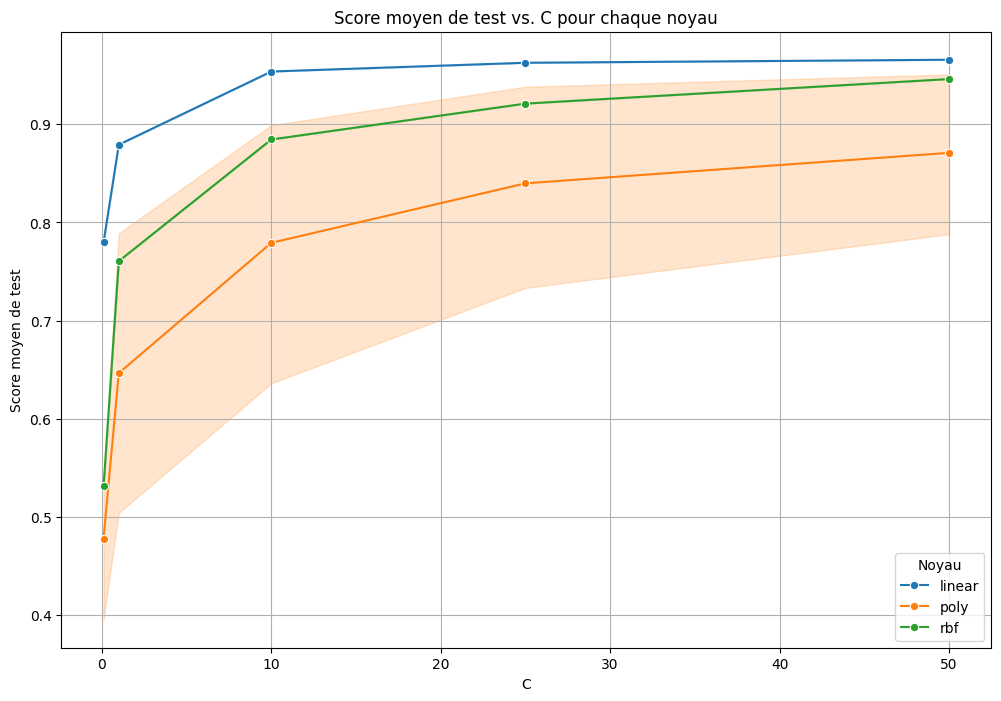

In [35]:
# Calculer le nombre d'échantillons à sélectionner : 1% du total soit 1,25% de 80%
n_samples = int(0.0125 * len(X_train))

# Sélectionner aléatoirement les indices de X_train avec un random_state pour la reproductibilité
#random_indices = np.random.choice(len(X_train), size=n_samples, replace=False, random_state=42)
rdmstt = np.random.RandomState(42)
random_indices = rdmstt.choice(len(X_train), size=n_samples, replace=False)

# Sélectionner X_train_sample et y_train_sample
X_train_sample = X_train[random_indices]
y_train_sample = y_train.iloc[random_indices]

# Afficher les dimensions de l'échantillon sélectionné
print("Dimensions de l'échantillon sélectionné de X_train : ", X_train_sample.shape)
print("Dimensions de l'échantillon sélectionné de y_train : ", y_train_sample.shape)


# 4. Définir les paramètres à tester dans le GridSearch
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],  # Noyaux à tester
    'C': [0.1, 1, 10, 25, 50],  # Valeurs de C pour tester
    'gamma': ['auto'],  # Valeurs de gamma (appliqué uniquement aux noyaux 'rbf' et 'poly')
    'degree': [2, 3],  # Degré du polynôme (applicable uniquement pour le noyau 'poly')
    'coef0': [0, 1]  # Paramètre pour le noyau 'poly' et 'sigmoid'
}

# 5. Créer un modèle SVM
svm = SVC(random_state=42)

# 6. Configurer le GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)

# 7. Effectuer le Grid Search sur l'échantillon d'entraînement
grid_search.fit(X_train_sample, y_train_sample)

# 8. Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)


gridresults=pd.DataFrame.from_dict(grid_search.cv_results_).loc[:,['params', 'mean_test_score']]
print(gridresults)


gridresults.to_csv('svmGSResults2.csv', index=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supposons que grid_search soit déjà effectué
# gridresults = pd.DataFrame.from_dict(grid_search.cv_results_).loc[:, ['params', 'mean_test_score']]

# Extraire les paramètres du GridSearch
params_df = pd.json_normalize(gridresults['params'])

# Ajouter les scores moyens de test
results_df = pd.concat([params_df, gridresults['mean_test_score']], axis=1)

# Afficher un aperçu des résultats
print(results_df.head())

# Pour un graphique plus simple, nous pouvons commencer par tracer en fonction de 'C' et 'kernel'
# Assurez-vous de filtrer les résultats pour des valeurs valides
plt.figure(figsize=(12, 8))

# Visualisation du score moyen pour chaque combinaison de 'kernel' et 'C'
sns.lineplot(x='C', y='mean_test_score', hue='kernel', data=results_df, marker='o')
#sns.lineplot(x='C', y='mean_test_score', hue='kernel', data=results_df, marker='o', ci=None)

plt.title('Score moyen de test vs. C pour chaque noyau')
plt.xlabel('C')
plt.ylabel('Score moyen de test')
plt.grid(True)
plt.legend(title='Noyau')
plt.show()


Dimensions de l'échantillon sélectionné de X_train :  (34987, 22)
Dimensions de l'échantillon sélectionné de y_train :  (34987,)
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Meilleurs paramètres : {'C': 50, 'class_weight': 'balanced', 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
                                               params  mean_test_score
0   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.727270
1   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.411982
2   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.525367
3   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.727270
4   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.263151
5   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.525367
6   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.727270
7   {'C': 0.1, 'class_weight': 'balanced', 'coef0'...         0.539772
8   {'C': 0.1, 'class_weight': 'balanced', 'coe

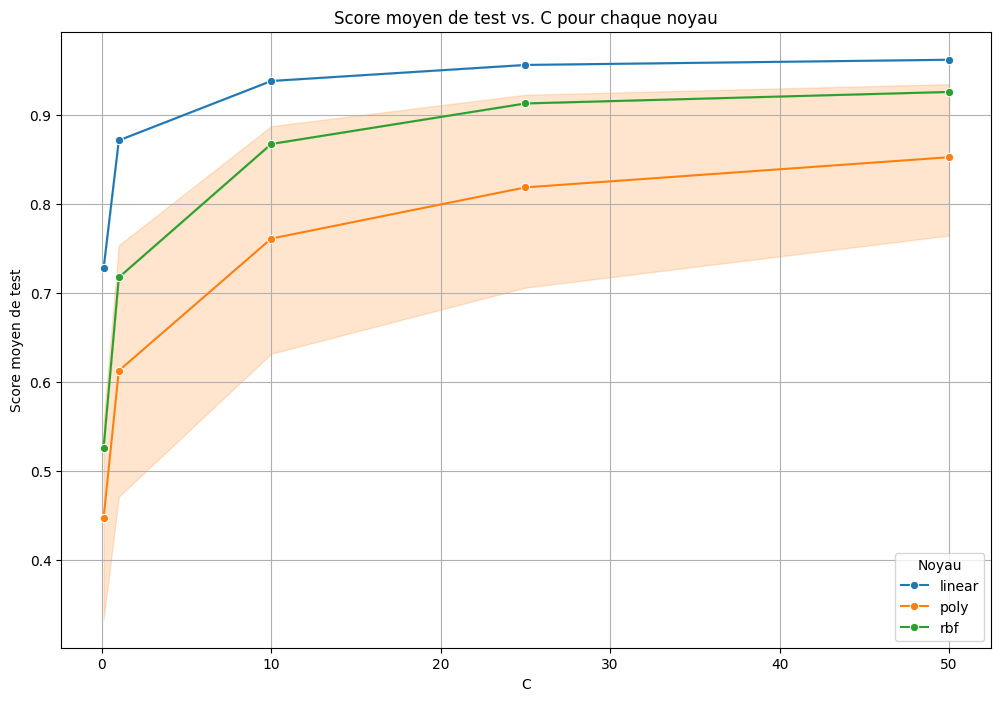

In [36]:
# Calculer le nombre d'échantillons à sélectionner : 1% du total soit 1,25% de 80%
n_samples = int(0.0125 * len(X_train))

# Sélectionner aléatoirement les indices de X_train avec un random_state pour la reproductibilité
#random_indices = np.random.choice(len(X_train), size=n_samples, replace=False, random_state=42)
rdmstt = np.random.RandomState(42)
random_indices = rdmstt.choice(len(X_train), size=n_samples, replace=False)

# Sélectionner X_train_sample et y_train_sample
X_train_sample = X_train[random_indices]
y_train_sample = y_train.iloc[random_indices]

# Afficher les dimensions de l'échantillon sélectionné
print("Dimensions de l'échantillon sélectionné de X_train : ", X_train_sample.shape)
print("Dimensions de l'échantillon sélectionné de y_train : ", y_train_sample.shape)


# 4. Définir les paramètres à tester dans le GridSearch
param_grid = {
    'class_weight' : ['balanced'],
    'kernel': ['linear', 'poly', 'rbf'],  # Noyaux à tester
    'C': [0.1, 1, 10, 25, 50],  # Valeurs de C pour tester
    'gamma': ['auto'],  # Valeurs de gamma (appliqué uniquement aux noyaux 'rbf' et 'poly')
    'degree': [2, 3],  # Degré du polynôme (applicable uniquement pour le noyau 'poly')
    'coef0': [0, 1]  # Paramètre pour le noyau 'poly' et 'sigmoid'
}

# 5. Créer un modèle SVM
svm = SVC(random_state=42)

# 6. Configurer le GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)

# 7. Effectuer le Grid Search sur l'échantillon d'entraînement
grid_search.fit(X_train_sample, y_train_sample)

# 8. Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)


gridresults=pd.DataFrame.from_dict(grid_search.cv_results_).loc[:,['params', 'mean_test_score']]
print(gridresults)


gridresults.to_csv('svmGSResults3.csv', index=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supposons que grid_search soit déjà effectué
# gridresults = pd.DataFrame.from_dict(grid_search.cv_results_).loc[:, ['params', 'mean_test_score']]

# Extraire les paramètres du GridSearch
params_df = pd.json_normalize(gridresults['params'])

# Ajouter les scores moyens de test
results_df = pd.concat([params_df, gridresults['mean_test_score']], axis=1)

# Afficher un aperçu des résultats
print(results_df.head())

# Pour un graphique plus simple, nous pouvons commencer par tracer en fonction de 'C' et 'kernel'
# Assurez-vous de filtrer les résultats pour des valeurs valides
plt.figure(figsize=(12, 8))

# Visualisation du score moyen pour chaque combinaison de 'kernel' et 'C'
sns.lineplot(x='C', y='mean_test_score', hue='kernel', data=results_df, marker='o')
#sns.lineplot(x='C', y='mean_test_score', hue='kernel', data=results_df, marker='o', ci=None)

plt.title('Score moyen de test vs. C pour chaque noyau')
plt.xlabel('C')
plt.ylabel('Score moyen de test')
plt.grid(True)
plt.legend(title='Noyau')
plt.show()


In [39]:
# 5. Créer un modèle SVM
svm = SVC(class_weight = 'balanced',
          kernel = 'linear',
          C = 25,
          random_state = 42)

svm.fit(X_train, y_train)

savePickleModel(svm, 'SVMClassifier-linear2.pkl')

### Entrainement du modèle ou récupération du modèle entraîné

In [8]:

if modelAlreadyTrain('SVMClassifier.pkl') :
    svm = loadPickleModel('SVMClassifier.pkl')
else:
    svm = svm.SVC(
                kernel='linear',
                random_state=42,
                )
    svm.fit(X_train, y_train)
    savePickleModel(svm, 'SVMClassifier.pkl')

### Calcul des prédictions du modèle sur l'échantillon de test

In [40]:
y_pred = svm.predict(X_test)

In [41]:
save_data = {
    'model': svm,
    #'shap_values': shap_values,
    #'predictions_train' : y_pred_train,
    'predictions_test': y_pred
}
with open('SVMClassifier-linear_modele_et_previsions.pkl', 'wb') as f:
    pickle.dump(save_data, f)

### Résultats du modèle

Résultats de la classification SVM

In [43]:
class_mapping = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G'}
print(classification_report(y_test, y_pred, target_names=[class_mapping[i] for i in sorted(class_mapping.keys())], digits=16))

                  precision    recall  f1-score   support

               A  0.9988086035196216 0.9994721610454852 0.9991402721107002    109882
               B  0.9283947857432272 0.9857729909356595 0.9562239171103756    134814
               C  0.9917953242170269 0.9286956378070491 0.9592088787827723    242103
               D  0.9387852702056433 0.9918232267517747 0.9645757152626212    118751
               E  0.9825541395013596 0.9670923220792622 0.9747619202392174     62022
               F  0.9415332170604090 0.9671416938110750 0.9541656624086126     24560
               G  0.9226559649762860 0.9948859166011015 0.9574105621805792      7626

        accuracy                      0.9669928746795321    699758
       macro avg  0.9577896150319392 0.9764119927187725 0.9664981325849826    699758
    weighted avg  0.9683493688650959 0.9669928746795321 0.9669968559380594    699758



Matrice de confusion

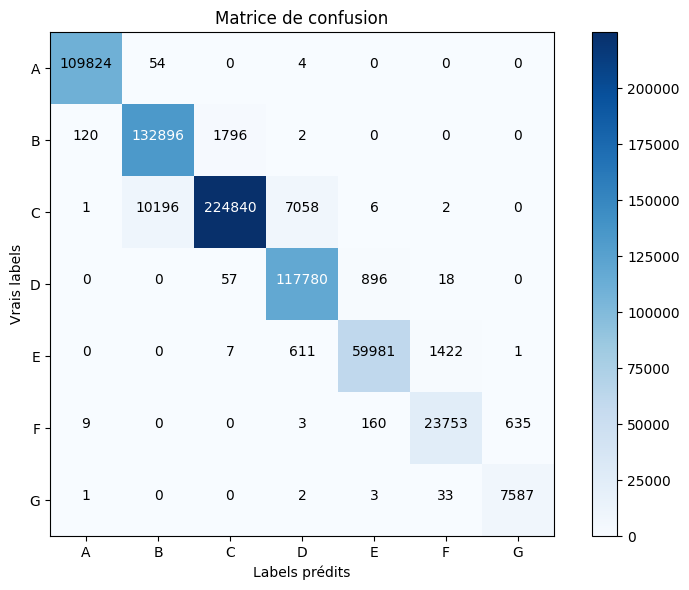

In [44]:
cnf_matrix = confusion_matrix(y_test, y_pred)

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize=(8, 6))

plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))

# Ajouter des étiquettes aux axes
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Afficher les valeurs dans chaque case de la matrice
threshold = cnf_matrix.max() / 2  # Seuil pour la couleur du texte
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cnf_matrix[i, j] > threshold else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.tight_layout()
plt.show()

In [47]:
# coefficients du modèle (poids des caractéristiques)
coefficients = svm.coef_

# Afficher les importances des caractéristiques
# Prenons la valeur absolue des coefficients pour les interpréter comme les importances
importances = np.abs(coefficients).flatten()

# Afficher les importances des caractéristiques
for i, importance in enumerate(importances):
    print(f"Feature {i + 1}: {importance:.4f}")

Feature 1: 1.6990
Feature 2: 16.6582
Feature 3: 24.4657
Feature 4: 9.1590
Feature 5: 119.5786
Feature 6: 7.8425
Feature 7: 4.8506
Feature 8: 251.8018
Feature 9: 1.9995
Feature 10: 0.0000
Feature 11: 0.0000
Feature 12: 0.0000
Feature 13: 0.0000
Feature 14: 0.0000
Feature 15: 0.0000
Feature 16: 38.0901
Feature 17: 11.6715
Feature 18: 22.8641
Feature 19: 0.0000
Feature 20: 5.1547
Feature 21: 12.3667
Feature 22: 22.8641
Feature 23: 0.3255
Feature 24: 0.7604
Feature 25: 1.2001
Feature 26: 3.3052
Feature 27: 4.6715
Feature 28: 1.9867
Feature 29: 7.7864
Feature 30: 38.5317
Feature 31: 0.0456
Feature 32: 0.7418
Feature 33: 0.0000
Feature 34: 0.0000
Feature 35: 0.0000
Feature 36: 0.0000
Feature 37: 0.0000
Feature 38: 5.2506
Feature 39: 1.7625
Feature 40: 2.6024
Feature 41: 0.0000
Feature 42: 0.9772
Feature 43: 1.6251
Feature 44: 2.6024
Feature 45: 2.4067
Feature 46: 1.3807
Feature 47: 3.1415
Feature 48: 7.6624
Feature 49: 5.7865
Feature 50: 6.5791
Feature 51: 3.9616
Feature 52: 24.7478
Feature 

In [52]:
svm = SVC(class_weight = 'balanced',
          kernel = 'linear',
          C = 25,
          probability=True,
          random_state = 42)

svm.fit(X_train, y_train)

savePickleModel(svm, 'SVMClassifier-linear3.pkl')

In [53]:
# coefficients du modèle (poids des caractéristiques)
coefficients = svm.coef_

# Afficher les importances des caractéristiques
# Prenons la valeur absolue des coefficients pour les interpréter comme les importances
importances = np.abs(coefficients).flatten()

# Afficher les importances des caractéristiques
for i, importance in enumerate(importances):
    print(f"Feature {i + 1}: {importance:.4f}")

Feature 1: 1.6990
Feature 2: 16.6582
Feature 3: 24.4657
Feature 4: 9.1590
Feature 5: 119.5786
Feature 6: 7.8425
Feature 7: 4.8506
Feature 8: 251.8018
Feature 9: 1.9995
Feature 10: 0.0000
Feature 11: 0.0000
Feature 12: 0.0000
Feature 13: 0.0000
Feature 14: 0.0000
Feature 15: 0.0000
Feature 16: 38.0901
Feature 17: 11.6715
Feature 18: 22.8641
Feature 19: 0.0000
Feature 20: 5.1547
Feature 21: 12.3667
Feature 22: 22.8641
Feature 23: 0.3255
Feature 24: 0.7604
Feature 25: 1.2001
Feature 26: 3.3052
Feature 27: 4.6715
Feature 28: 1.9867
Feature 29: 7.7864
Feature 30: 38.5317
Feature 31: 0.0456
Feature 32: 0.7418
Feature 33: 0.0000
Feature 34: 0.0000
Feature 35: 0.0000
Feature 36: 0.0000
Feature 37: 0.0000
Feature 38: 5.2506
Feature 39: 1.7625
Feature 40: 2.6024
Feature 41: 0.0000
Feature 42: 0.9772
Feature 43: 1.6251
Feature 44: 2.6024
Feature 45: 2.4067
Feature 46: 1.3807
Feature 47: 3.1415
Feature 48: 7.6624
Feature 49: 5.7865
Feature 50: 6.5791
Feature 51: 3.9616
Feature 52: 24.7478
Feature 

In [67]:
sample_size=50

In [68]:
# Stratified Shuffle Split pour sélectionner un échantillon représentatif
splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=sample_size / X_test.shape[0],
    random_state=42,
)

# Sélection d'un échantillon des données de test
for _, test_idx in splitter.split(X_test, y_test):
    X_test_sample = X_test[test_idx]
    
print(f"Taille de l'ensemble de test: {X_test_sample.shape[0]}")

Taille de l'ensemble de test: 50


In [ ]:
explainer = shap.KernelExplainer(svm.predict_proba, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

In [72]:
# Sauvegarder les SHAP values dans un fichier .npy
np.save('shap_values.npy', shap_values)

# Restaurer les SHAP values
shap_values_loaded = np.load('shap_values.npy', allow_pickle=True)

print(shap_values_loaded)

[[[ 2.50276982e-02 -7.63084590e-03 -1.31734942e-02 ...  4.63001792e-03
    4.41514986e-02  1.65329198e-01]
  [ 2.98141846e-03 -1.67705334e-03  0.00000000e+00 ...  6.32419163e-03
   -1.28511200e-02 -2.10875597e-02]
  [ 3.89806642e-03 -1.52659283e-02  3.57106941e-03 ...  3.24673965e-03
   -1.34139974e-02 -7.02493763e-03]
  ...
  [-1.61791712e-02 -7.16615848e-03  7.10450716e-04 ... -2.93514054e-03
    1.86496307e-02 -1.65269465e-02]
  [-1.53328650e-02 -5.23604803e-03  2.18612854e-03 ...  3.61519272e-03
   -1.35591138e-02 -1.71674309e-02]
  [-7.20482556e-03 -1.74177250e-02  1.64501663e-03 ...  4.61254856e-03
   -2.43470257e-02 -1.76478134e-02]]

 [[-5.78148870e-03  5.76179805e-03 -2.58187350e-03 ...  2.16681547e-02
    2.02366592e-02 -7.08829001e-02]
  [-4.18606171e-03  1.79232797e-03 -5.10166787e-03 ...  4.41696229e-02
   -3.28795083e-02 -3.03202330e-04]
  [-3.49140074e-03  6.91739766e-03 -3.77608137e-02 ...  2.10823568e-02
   -1.36421380e-02  0.00000000e+00]
  ...
  [ 9.03171821e-03  1.1

In [113]:
className = {0: "A", 1: "B", 2: "C", 3:"D", 4 :"E", 5 :"G", 6: "F" }
num_features = X_test_sample.shape[1]
num_classes = len(np.unique(y_test))


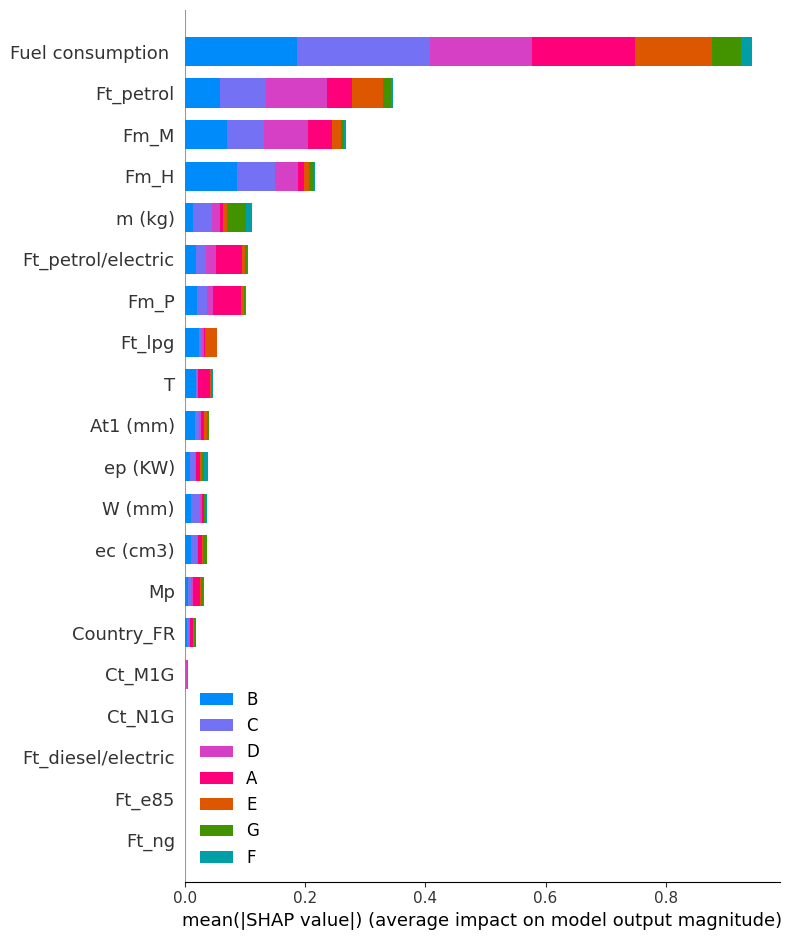

In [114]:

# Visualisation des SHAP globales
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=X.columns,
    class_names=className,
    cmap='coolwarm',
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


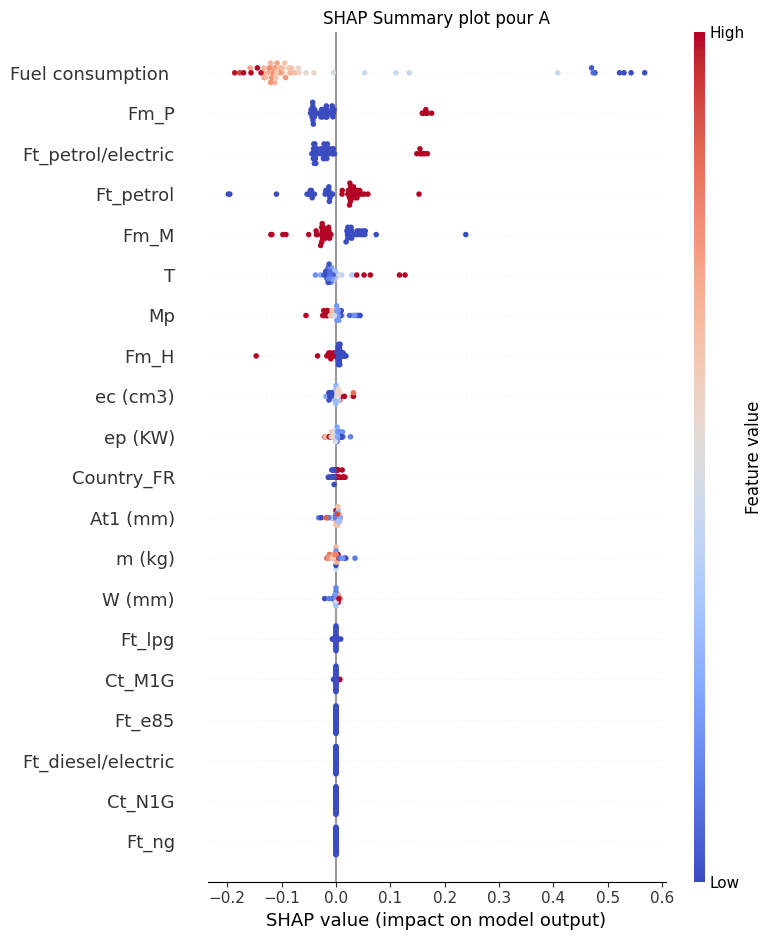

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


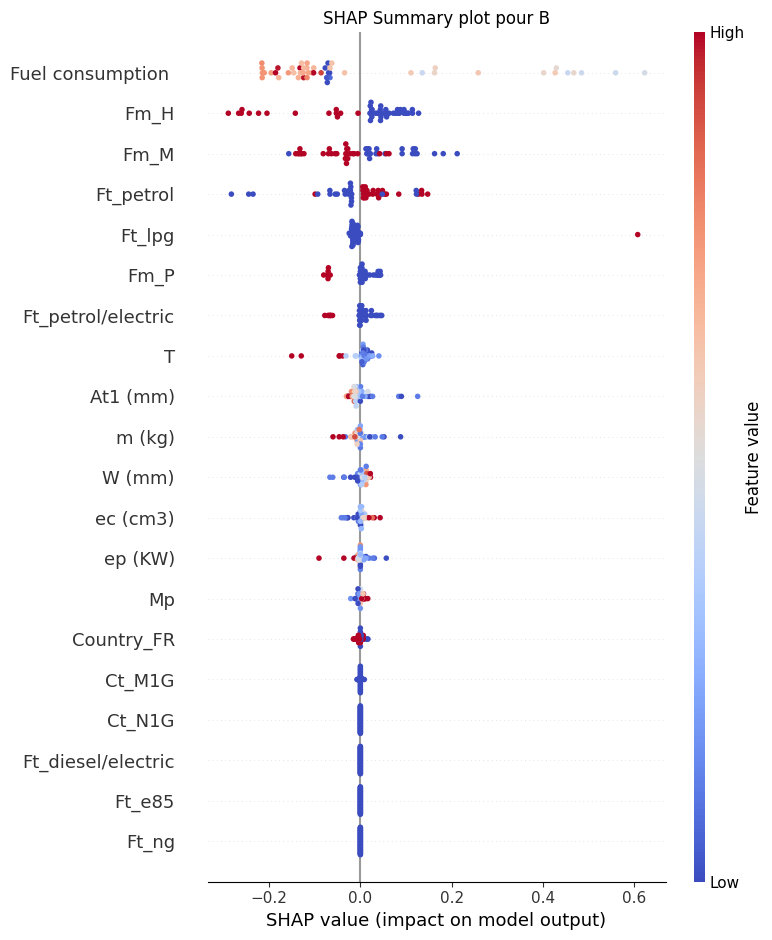

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


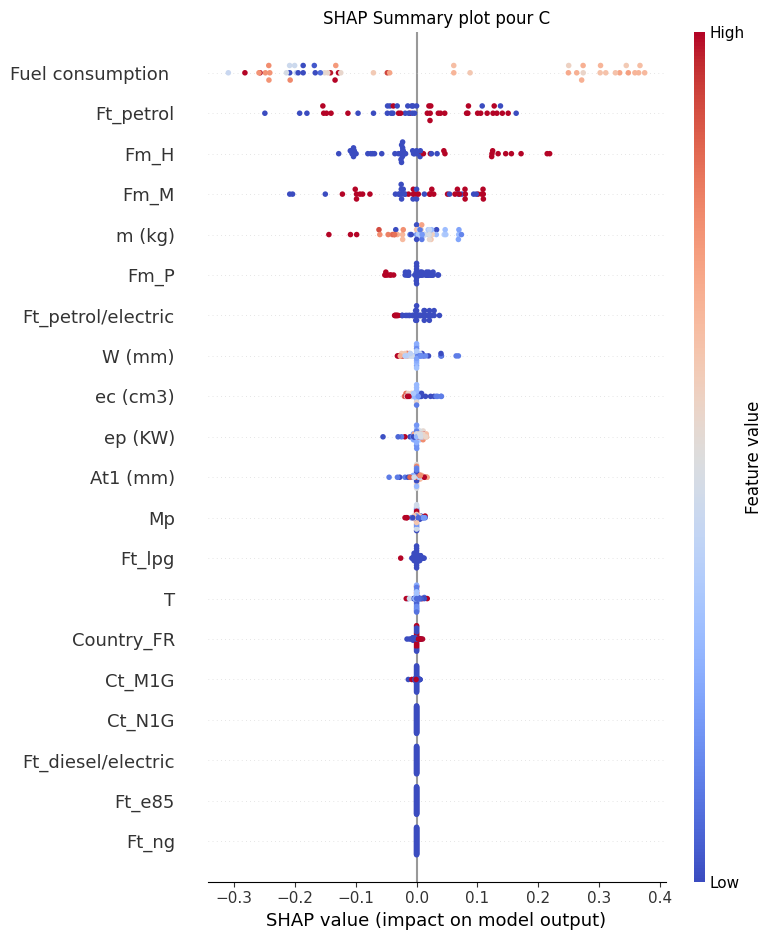

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


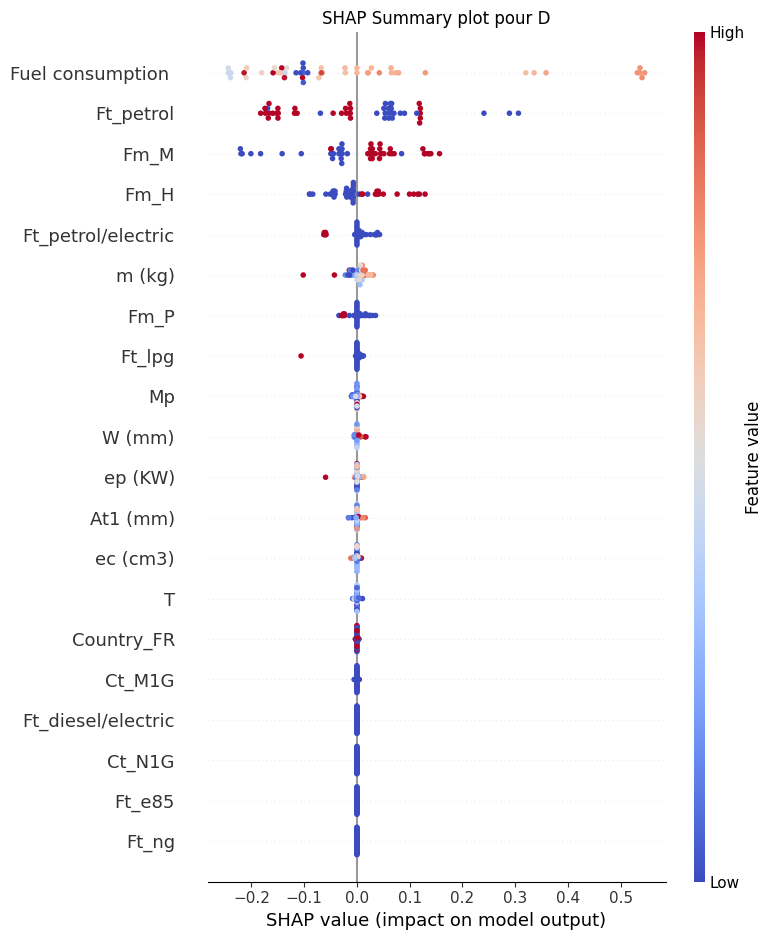

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


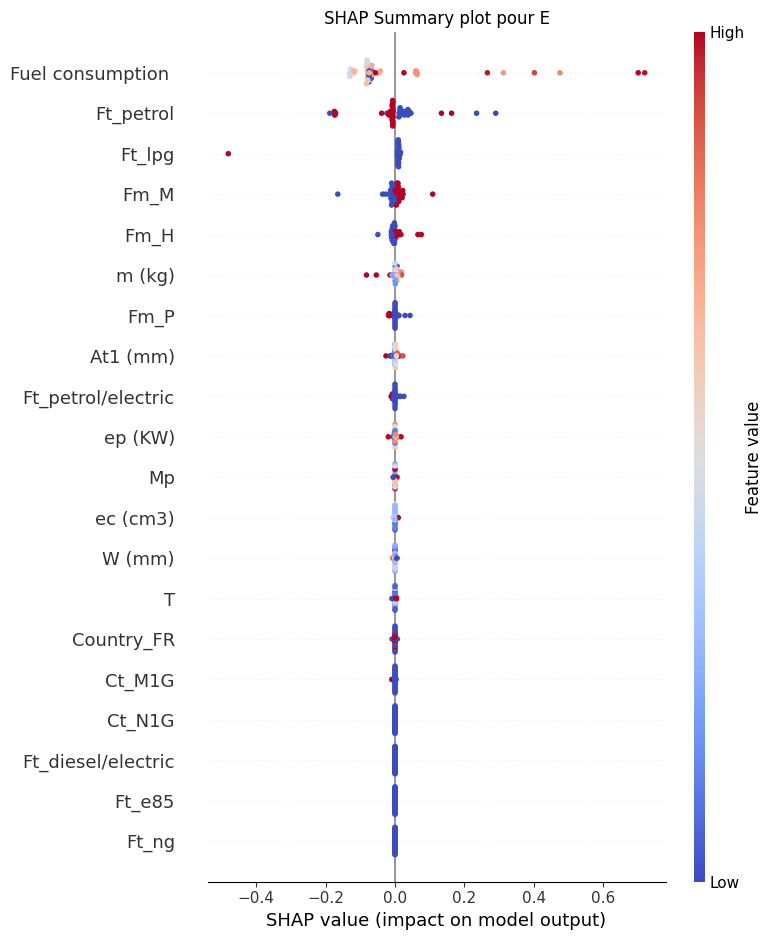

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


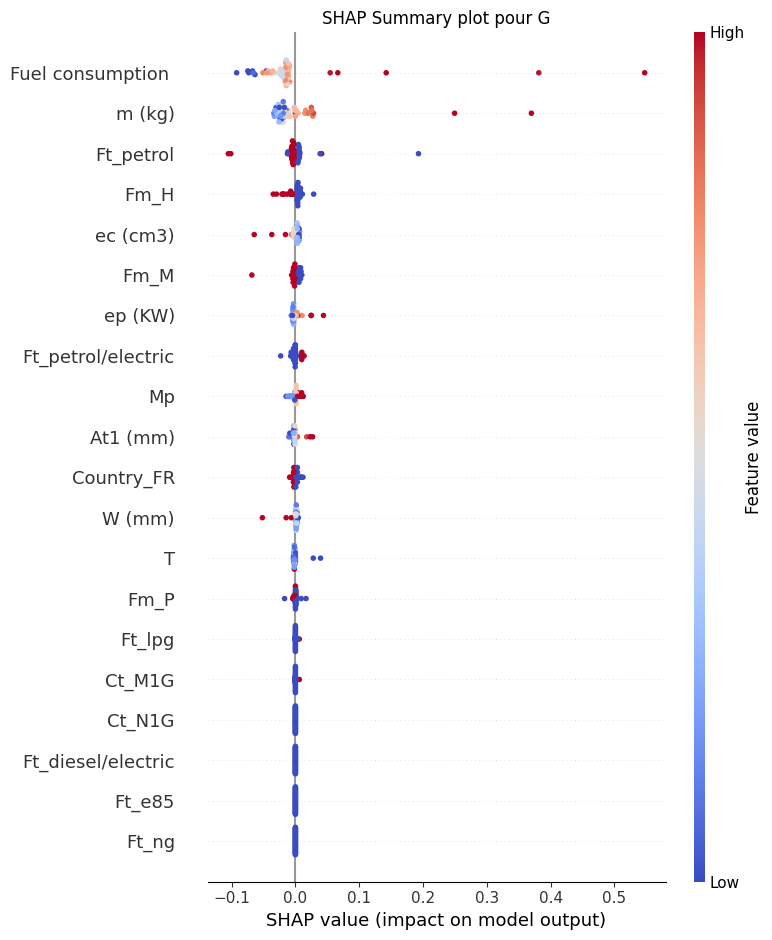

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


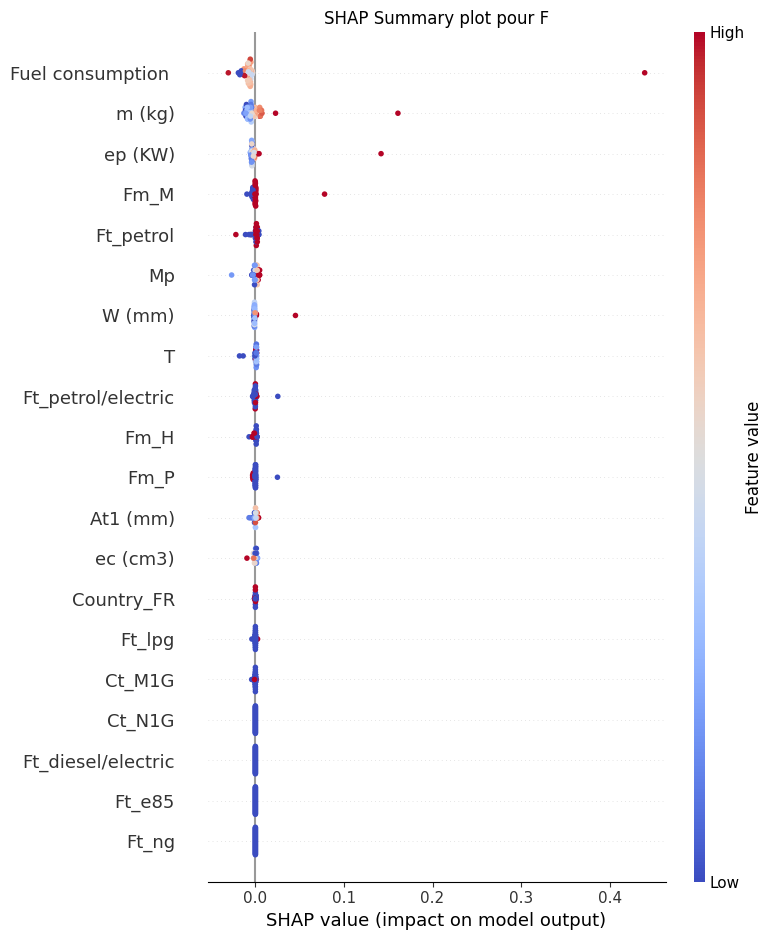

In [115]:
# SHAP par classe
for i in range(num_classes):
    plt.title(f"SHAP Summary plot pour {className[i]}")
    shap.summary_plot(
        shap_values[i],
        X_test_sample,
        class_names=[className[j] for j in range(num_classes)],
        feature_names=X.columns,
        cmap='coolwarm',
    )